In [4]:
pip install catboost

  Obtaining dependency information for catboost from https://files.pythonhosted.org/packages/8c/fa/676389207a5f2561f0d8ad87972291a649928f33777c76b6d108c81ac037/catboost-1.2.7-cp311-cp311-macosx_11_0_universal2.whl.metadata
  Using cached catboost-1.2.7-cp311-cp311-macosx_11_0_universal2.whl.metadata (1.2 kB)
  Obtaining dependency information for matplotlib from https://files.pythonhosted.org/packages/0c/f1/e37f6c84d252867d7ddc418fff70fc661cfd363179263b08e52e8b748e30/matplotlib-3.10.0-cp311-cp311-macosx_10_12_x86_64.whl.metadata
  Using cached matplotlib-3.10.0-cp311-cp311-macosx_10_12_x86_64.whl.metadata (11 kB)
  Obtaining dependency information for pandas>=0.24 from https://files.pythonhosted.org/packages/a8/44/d9502bf0ed197ba9bf1103c9867d5904ddcaf869e52329787fc54ed70cc8/pandas-2.2.3-cp311-cp311-macosx_10_9_x86_64.whl.metadata
  Using cached pandas-2.2.3-cp311-cp311-macosx_10_9_x86_64.whl.metadata (89 kB)
  Obtaining dependency information for contourpy>=1.0.1 from https://files.pyt

In [6]:
pip install shap

  Obtaining dependency information for shap from https://files.pythonhosted.org/packages/e5/a1/43bd69f32ddf381a09de18ea94d4b215d5ced3a24ff1a7b7d1a9401b5b85/shap-0.46.0-cp311-cp311-macosx_10_9_x86_64.whl.metadata
  Obtaining dependency information for scikit-learn from https://files.pythonhosted.org/packages/6c/2a/e291c29670795406a824567d1dfc91db7b699799a002fdaa452bceea8f6e/scikit_learn-1.6.1-cp311-cp311-macosx_10_9_x86_64.whl.metadata
  Obtaining dependency information for tqdm>=4.27.0 from https://files.pythonhosted.org/packages/d0/30/dc54f88dd4a2b5dc8a0279bdd7270e735851848b762aeb1c1184ed1f6b14/tqdm-4.67.1-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 1.9 MB/s eta 0:00:00
  Obtaining dependency information for slicer==0.0.8 from https://files.pythonhosted.org/packages/63/81/9ef641ff4e12cbcca30e54e72fb0951a2ba195d0cda0ba4100e532d929db/slicer-0.0.8-py3-none-any.whl.metadata
  Obtaining dependency information for numba from https://files.pythonhoste

100%|===================| 305716/305977 [09:47<00:00]        

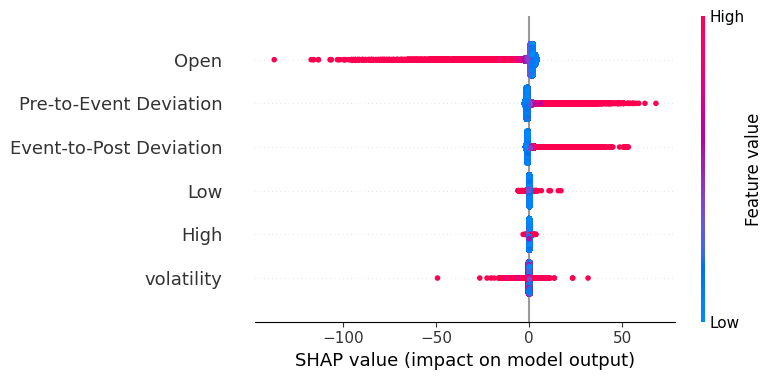

SHAP summary plot saved as 'shap_summary_plot.png'.
Feature importance plot saved as 'feature_importance_plot.png'.


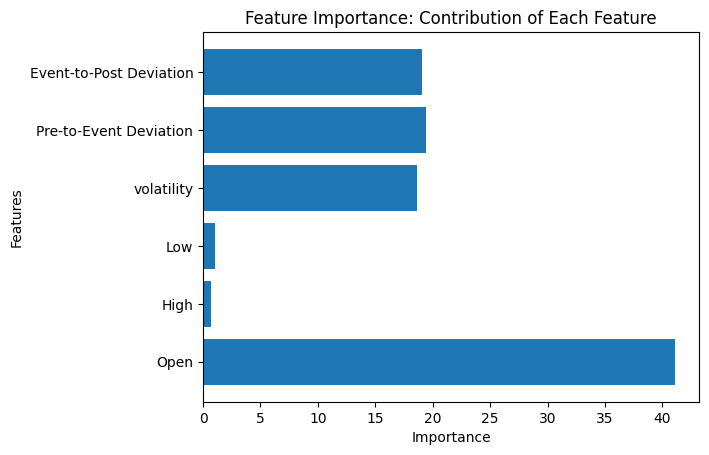

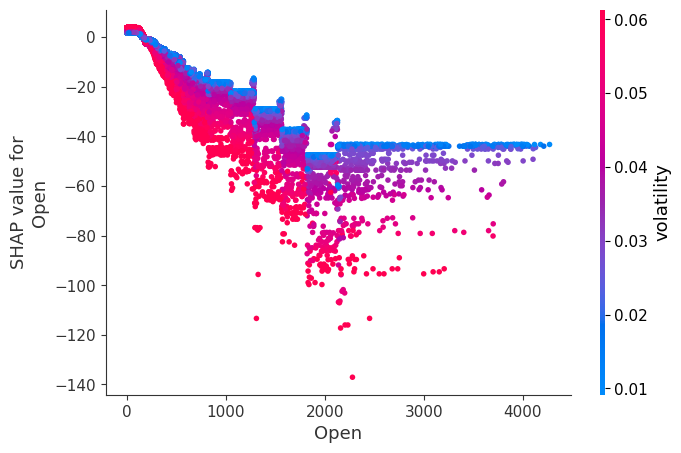

SHAP dependence plot for the first feature saved as 'shap_dependence_plot_feature_1.png'.
Correlation matrix heatmap saved as 'correlation_matrix_heatmap.png'.


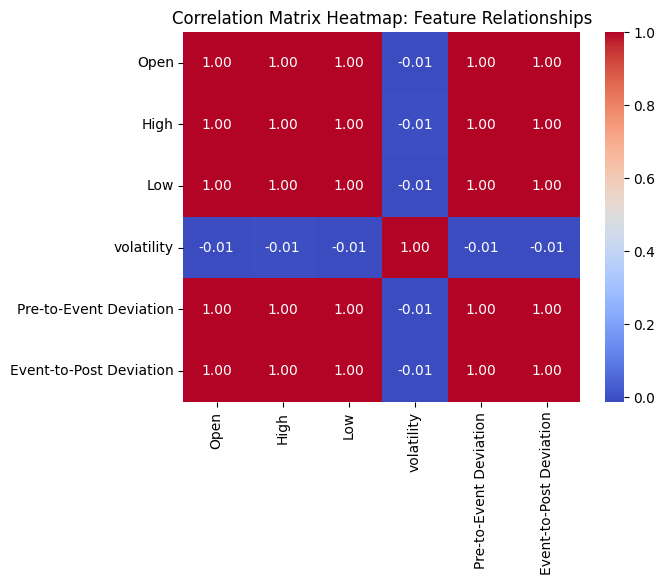

In [21]:
import pandas as pd
import shap
from catboost import CatBoostRegressor
import matplotlib.pyplot as plt

# Load data from uploaded files
stock_metadata = pd.read_csv('/Users/erolberkiyibozkurt/Documents/GitHub/Python/Projects/The Influence of AI Boom on Tech Stocks/Extracted Data/stock_metadata_top100.csv')
stock_timeseries_usd = pd.read_csv('/Users/erolberkiyibozkurt/Documents/GitHub/Python/Projects/The Influence of AI Boom on Tech Stocks/Extracted Data/stock_timeseries_usd_full.csv')
stock_timeseries_diff_currency = pd.read_csv('/Users/erolberkiyibozkurt/Documents/GitHub/Python/Projects/The Influence of AI Boom on Tech Stocks/Extracted Data/stock_timeseries_different_currency.csv')
mwe_table = pd.read_csv('/Users/erolberkiyibozkurt/Documents/GitHub/Python/Projects/The Influence of AI Boom on Tech Stocks/Extracted Data/mwe_table_for_ai_events.csv')
timeline_data = pd.read_csv('/Users/erolberkiyibozkurt/Documents/GitHub/Python/Projects/The Influence of AI Boom on Tech Stocks/Background Data/timeline_of_the_ai.csv')

# Preprocessing: Merge datasets for analysis if necessary
merged_data = stock_timeseries_usd.merge(stock_metadata, on='Symbol', how='inner')

# Use MWE as a reference for average values, not direct merging
mwe_averages = mwe_table[['Pre-Event Avg', 'Event-Day Avg', 'Post-Event Avg']].mean()
merged_data['Pre-Event Avg'] = mwe_averages['Pre-Event Avg']
merged_data['Event-Day Avg'] = mwe_averages['Event-Day Avg']
merged_data['Post-Event Avg'] = mwe_averages['Post-Event Avg']

# Calculate individual stock deviations from average
merged_data['Pre-to-Event Deviation'] = (merged_data['Close'] - merged_data['Pre-Event Avg']) / merged_data['Pre-Event Avg']
merged_data['Event-to-Post Deviation'] = (merged_data['Close'] - merged_data['Post-Event Avg']) / merged_data['Post-Event Avg']

# Feature Engineering: Create new features if required
merged_data['price_change'] = merged_data['Close'] - merged_data['Open']
merged_data['volatility'] = (merged_data['High'] - merged_data['Low']) / merged_data['Open']

# Select features and target
features = ['Open', 'High', 'Low', 'volatility', 'Pre-to-Event Deviation', 'Event-to-Post Deviation']
target = 'price_change'

# Filter for non-null and numeric values
filtered_data = merged_data.dropna(subset=features + [target])
X = filtered_data[features]
y = filtered_data[target]

# Train a model
model = CatBoostRegressor(iterations=100, depth=5, learning_rate=0.1, verbose=0)
model.fit(X, y)

# SHAP Analysis
explainer = shap.Explainer(model, X)
shap_values = explainer(X)

# Visualize SHAP summary plot
shap.summary_plot(shap_values, X)
plt.title("SHAP Summary Plot: Feature Importance Visualization")
plt.savefig('shap_summary_plot.png')
print("SHAP summary plot saved as 'shap_summary_plot.png'.")

# Additional visualizations
# Feature importance plot
plt.barh(features, model.feature_importances_)
plt.title("Feature Importance: Contribution of Each Feature")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.savefig('feature_importance_plot.png')
print("Feature importance plot saved as 'feature_importance_plot.png'.")

# SHAP dependence plot for the first feature
shap.dependence_plot(0, shap_values.values, X)
plt.title("SHAP Dependence Plot: First Feature Analysis")
plt.savefig('shap_dependence_plot_feature_1.png')
print("SHAP dependence plot for the first feature saved as 'shap_dependence_plot_feature_1.png'.")

# Correlation matrix heatmap
import seaborn as sns
correlation_matrix = X.corr()
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.title("Correlation Matrix Heatmap: Feature Relationships")
plt.savefig('correlation_matrix_heatmap.png')
print("Correlation matrix heatmap saved as 'correlation_matrix_heatmap.png'.")


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


Country vs AI Event Impact Correlation heatmap saved as 'country_vs_ai_event_correlation.png'.


100%|===================| 305530/305977 [10:41<00:00]        

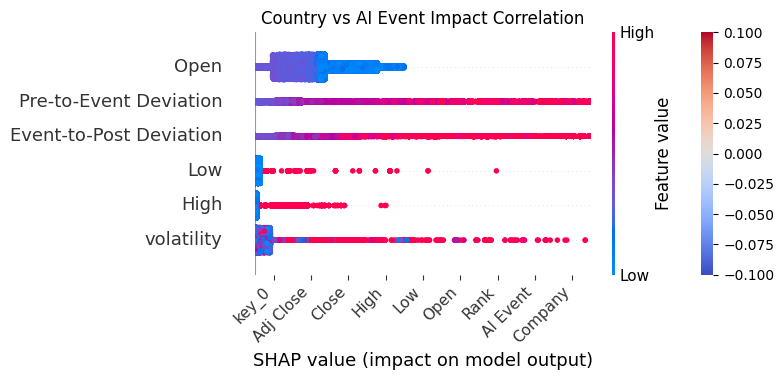

SHAP summary plot saved as 'shap_summary_plot.png'.
Feature importance plot saved as 'feature_importance_plot.png'.


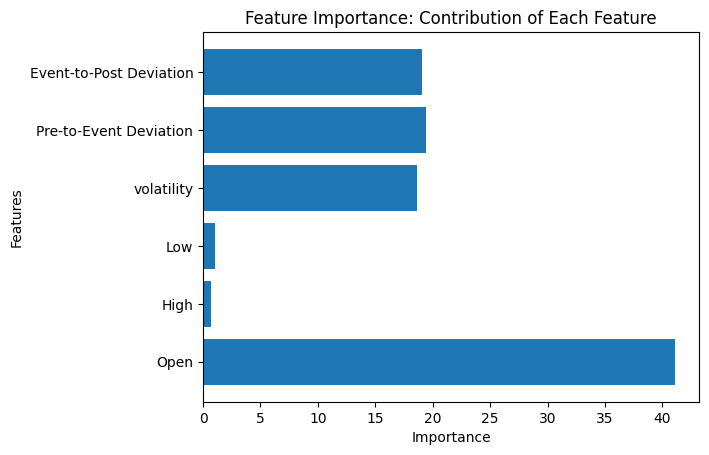

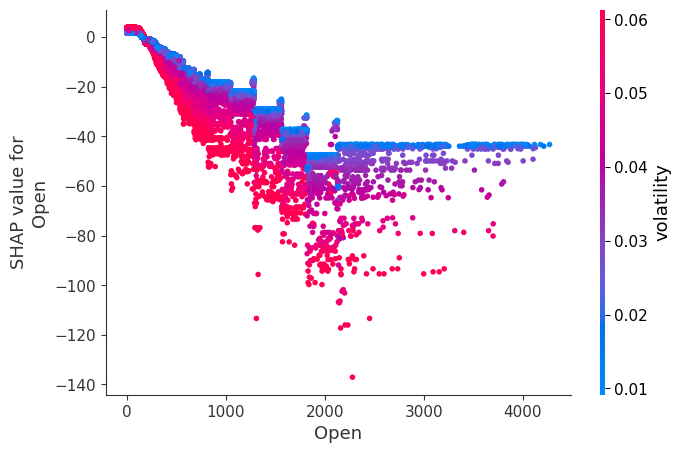

SHAP dependence plot for the first feature saved as 'shap_dependence_plot_feature_1.png'.
Correlation matrix heatmap saved as 'correlation_matrix_heatmap.png'.


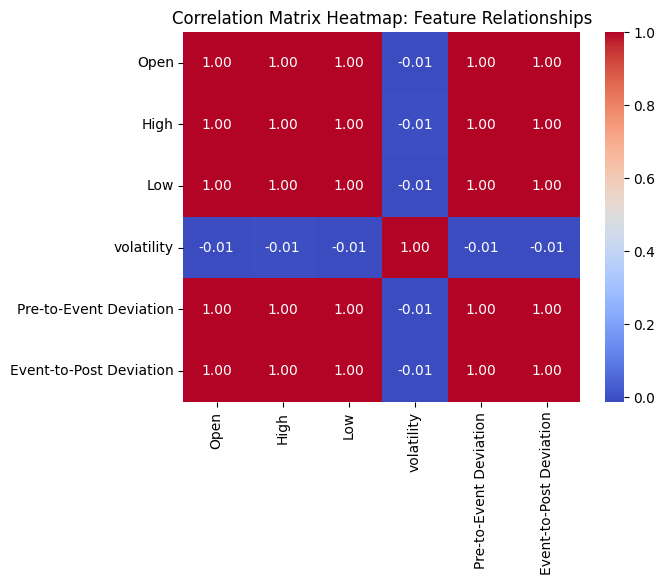

In [26]:
import pandas as pd
import shap
from catboost import CatBoostRegressor
import matplotlib.pyplot as plt
import seaborn as sns

# Load data from uploaded files
stock_metadata = pd.read_csv('/Users/erolberkiyibozkurt/Documents/GitHub/Python/Projects/The Influence of AI Boom on Tech Stocks/Extracted Data/stock_metadata_top100.csv')
stock_timeseries_usd = pd.read_csv('/Users/erolberkiyibozkurt/Documents/GitHub/Python/Projects/The Influence of AI Boom on Tech Stocks/Extracted Data/stock_timeseries_usd_full.csv')
stock_timeseries_diff_currency = pd.read_csv('/Users/erolberkiyibozkurt/Documents/GitHub/Python/Projects/The Influence of AI Boom on Tech Stocks/Extracted Data/stock_timeseries_different_currency.csv')
mwe_table = pd.read_csv('/Users/erolberkiyibozkurt/Documents/GitHub/Python/Projects/The Influence of AI Boom on Tech Stocks/Extracted Data/mwe_table_for_ai_events.csv')
timeline_data = pd.read_csv('/Users/erolberkiyibozkurt/Documents/GitHub/Python/Projects/The Influence of AI Boom on Tech Stocks/Background Data/timeline_of_the_ai.csv')

# Preprocessing: Merge datasets for analysis if necessary
merged_data = stock_timeseries_usd.merge(stock_metadata, on='Symbol', how='inner')

# Group stock prices by country and correlate with AI Event timeline
if 'Country' in stock_metadata.columns:
    stock_by_country = merged_data.groupby('Country').mean(numeric_only=True)
    ai_event_impact = timeline_data.set_index('Date')  # Assuming timeline_data has 'Date' as an index
    combined = stock_by_country.merge(ai_event_impact, left_on=stock_by_country.index, right_index=True, how='inner')

    # Plot country-wise AI event impact correlation
    plt.figure(figsize=(12, 6))
    sns.heatmap(combined.corr(), annot=True, fmt='.2f', cmap='coolwarm')
    plt.title("Country vs AI Event Impact Correlation")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig('country_vs_ai_event_correlation.png')
    print("Country vs AI Event Impact Correlation heatmap saved as 'country_vs_ai_event_correlation.png'.")

# Use MWE as a reference for average values, not direct merging
mwe_averages = mwe_table[['Pre-Event Avg', 'Event-Day Avg', 'Post-Event Avg']].mean()
merged_data['Pre-Event Avg'] = mwe_averages['Pre-Event Avg']
merged_data['Event-Day Avg'] = mwe_averages['Event-Day Avg']
merged_data['Post-Event Avg'] = mwe_averages['Post-Event Avg']

# Calculate individual stock deviations from average
merged_data['Pre-to-Event Deviation'] = (merged_data['Close'] - merged_data['Pre-Event Avg']) / merged_data['Pre-Event Avg']
merged_data['Event-to-Post Deviation'] = (merged_data['Close'] - merged_data['Post-Event Avg']) / merged_data['Post-Event Avg']

# Feature Engineering: Create new features if required
merged_data['price_change'] = merged_data['Close'] - merged_data['Open']
merged_data['volatility'] = (merged_data['High'] - merged_data['Low']) / merged_data['Open']

# Select features and target
features = ['Open', 'High', 'Low', 'volatility', 'Pre-to-Event Deviation', 'Event-to-Post Deviation']
target = 'price_change'

# Filter for non-null and numeric values
filtered_data = merged_data.dropna(subset=features + [target])
X = filtered_data[features]
y = filtered_data[target]

# Train a model
model = CatBoostRegressor(iterations=100, depth=5, learning_rate=0.1, verbose=0)
model.fit(X, y)

# SHAP Analysis
explainer = shap.Explainer(model, X)
shap_values = explainer(X)

# Visualize SHAP summary plot
shap.summary_plot(shap_values, X)
plt.title("SHAP Summary Plot: Feature Importance Visualization")
plt.savefig('shap_summary_plot.png')
print("SHAP summary plot saved as 'shap_summary_plot.png'.")

# Additional visualizations
# Feature importance plot
plt.barh(features, model.feature_importances_)
plt.title("Feature Importance: Contribution of Each Feature")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.savefig('feature_importance_plot.png')
print("Feature importance plot saved as 'feature_importance_plot.png'.")

# SHAP dependence plot for the first feature
shap.dependence_plot(0, shap_values.values, X)
plt.title("SHAP Dependence Plot: First Feature Analysis")
plt.savefig('shap_dependence_plot_feature_1.png')
print("SHAP dependence plot for the first feature saved as 'shap_dependence_plot_feature_1.png'.")

# Correlation matrix heatmap
correlation_matrix = X.corr()
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.title("Correlation Matrix Heatmap: Feature Relationships")
plt.savefig('correlation_matrix_heatmap.png')
print("Correlation matrix heatmap saved as 'correlation_matrix_heatmap.png'.")
